In [178]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [179]:
market_data_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_1.csv"), sep=";")
market_data_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_2.csv"), sep=";")
market_data_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_3.csv"), sep=";")

trades_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_1.csv"), sep=";")
trades_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_2.csv"), sep=";")
trades_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_3.csv"), sep=";")

observations_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_1.csv"), sep=",")
observations_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_2.csv"), sep=",")
observations_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_3.csv"), sep=",")

market_data_round_4_all3days = concatenate_historical_data([market_data_round_4_day_1, market_data_round_4_day_2, market_data_round_4_day_3])
trades_round_4_all3days = concatenate_historical_data([trades_round_4_day_1, trades_round_4_day_2, trades_round_4_day_3])
observations_round_4_all3days = concatenate_historical_data([observations_round_4_day_1, observations_round_4_day_2, observations_round_4_day_3])

In [180]:
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

md = market_data_round_4_day_1.copy()
th = trades_round_4_day_1.copy()
obs = observations_round_4_day_1.copy()

md = md[md["product"] == MAGNIFICENT_MACARONS]
th = th[th["symbol"] == MAGNIFICENT_MACARONS]


l, h = 0, 1e6
md = md[(md["timestamp"] >= l) & (md["timestamp"] <= h)].reset_index(drop=True)
th = th[(th["timestamp"] >= l) & (th["timestamp"] <= h)].reset_index(drop=True)
obs = obs[(obs["timestamp"] >= l) & (obs["timestamp"] <= h)].reset_index(drop=True)

obs["actual_ask"] = obs["askPrice"] + obs["transportFees"] + obs["importTariff"]
obs["actual_bid"] = obs["bidPrice"] - obs["transportFees"] - obs["exportTariff"]

# plt.plot(obs["timestamp"], obs["actual_ask"], label="actual_ask")
# plt.plot(obs["timestamp"], obs["actual_bid"], label="actual_bid")

# plt.plot(obs['timestamp'], obs['actual_ask']- obs['actual_bid']) # crossing the 'spread' is like $16, thats crazy bruh
# plt.legend()
# plt.show()

obs


,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex,actual_ask,actual_bid
0,0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00,626.5,617.0
1,100,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00,629.5,620.0
2,200,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00,629.5,620.0
3,300,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01,631.5,622.0
4,400,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01,630.0,620.5
...,...,...,...,...,...,...,...,...,...,...
9995,999500,661.0,662.5,1.4,10.5,-4.0,209.926279,64.94,659.9,649.1
9996,999600,659.5,661.0,1.4,10.5,-4.0,209.565005,64.96,658.4,647.6
9997,999700,658.5,660.0,1.4,10.5,-4.0,209.504858,64.98,657.4,646.6
9998,999800,658.0,659.5,1.4,10.5,-4.0,209.482890,65.00,656.9,646.1


Heavy liquidity. This is the first one where I've seen that bid, ask for levels 1,2,3 are never NaN.  

Additionally, there is heavy liquidity at all 3 levels, and the spread is somewhat wide: $\mu = 7.75, \sigma = 1.12$.  

Mean spread: 2.425630000000007, std: 0.8052317077090259


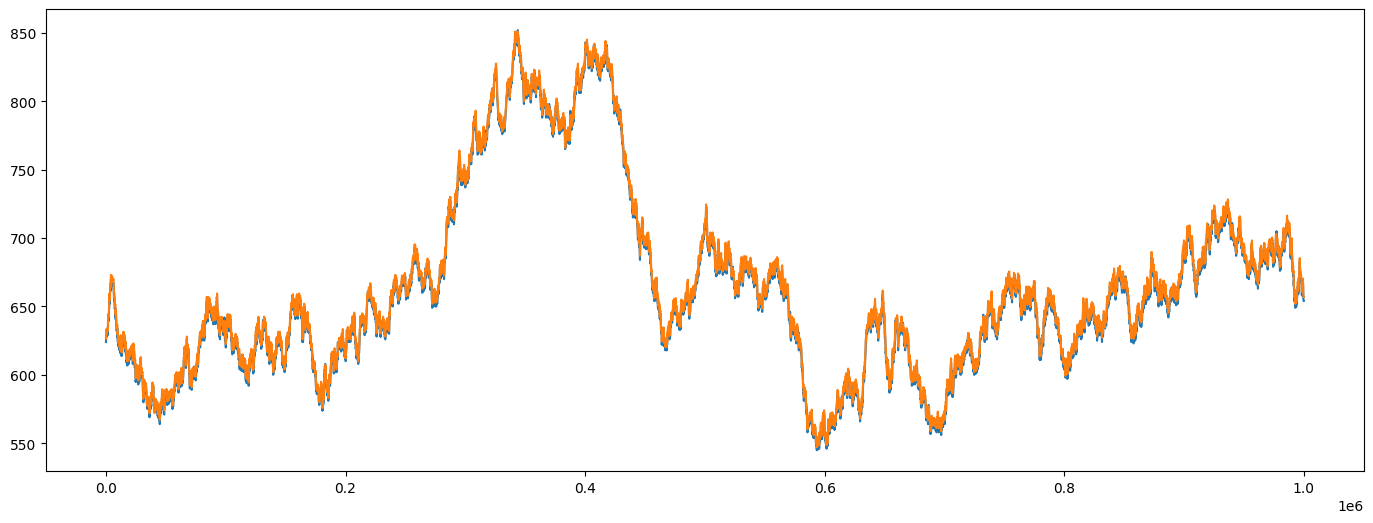

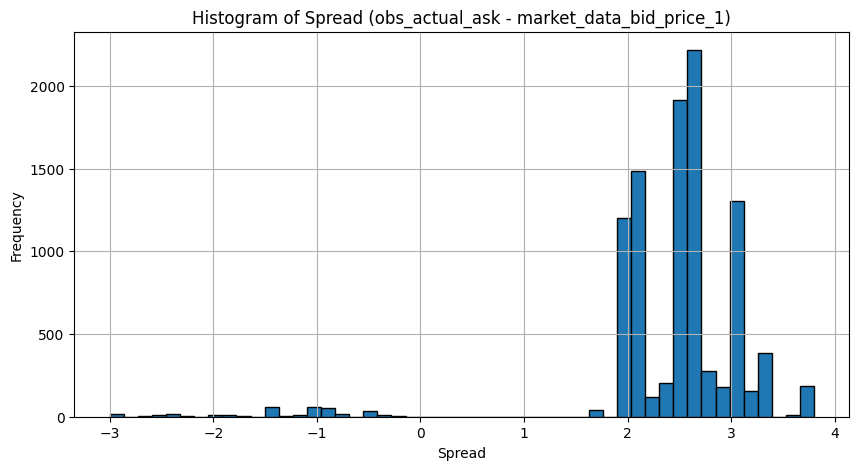

325
421.6999999999979
0


In [185]:
plt.figure(figsize=(17, 6))
# plt.plot(md["timestamp"], md["ask_price_1"], label="market_data_macaron_ask_price_1")
plt.plot(md["timestamp"], md["bid_price_1"], label="market_data_macaron_bid_price_1")
plt.plot(obs["timestamp"], obs["actual_ask"], label="obs_actual_ask")
# plt.plot(obs["timestamp"], obs["actual_bid"], label="obs_actual_bid")


spread = obs['actual_ask'] - md['bid_price_1']
print(f"Mean spread: {np.mean(spread)}, std: {np.std(spread)}")
# plt.figure()
# plt.plot(md['timestamp'], spread)
# plt.show()

#lets get a hitsorgram
plt.figure(figsize=(10, 5))
plt.hist(spread.dropna(), bins=50, edgecolor='black')  # dropna to avoid NaNs affecting the plot
plt.title("Histogram of Spread (obs_actual_ask - market_data_bid_price_1)")
plt.xlabel("Spread")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# plt.plot(md['timestamp'], obs['actual_ask'] - md['ask_price_1'], label='differnece between chef and market ask')
 


# mask = obs['actual_ask'] - md['ask_price_1'] >= 2
# print(np.sum(mask))
# md = md[mask]
# obs = obs[mask]

# plt.plot(md['timestamp'], md['ask_price_1'], label='market_data_macaron_ask_price_1')
# plt.plot(md['timestamp'], md['bid_price_1'], label='market_data_macaron_bid_price_1')
# plt.plot(obs['timestamp'], obs['actual_ask'], label='obs_actual_ask')
# plt.plot(obs['timestamp'], obs['actual_bid'], label='obs_actual_bid')


# plt.legend()
# plt.title("their island midprice vs our island midprice")
# plt.show()


# #arb: buy from chefs, sell to market
mask = obs["actual_ask"] < md["bid_price_1"]
print(np.sum(mask))
print(np.sum((md["bid_price_1"] - obs["actual_ask"])[mask]))

# arb: buy from market, sell to chefs
mask = obs["actual_bid"] > md["ask_price_1"]
print(np.sum(mask))


# lets plot some volumes over time

# plt.figure(figsize=(16, 3))

# colors_ask = ["blue", "orange", "green"]
# colors_bid = ["red", "purple", "brown"]
# for i in range(1, 4, 1):
#     plt.plot(md["timestamp"], md[f"ask_volume_{i}"].rolling(100).mean(), color=colors_ask[i - 1], label=f"ask_volume_{i}")

# plt.legend()
# plt.show()


# plt.figure(figsize=(16, 3))
# for i in range(1, 4, 1):
#     plt.plot(md["timestamp"], md[f"bid_volume_{i}"].rolling(100).mean(), color=colors_bid[i - 1], label=f"bid_volume_{i}")

# plt.legend()
# plt.show()


So we calculate the actual_ask and the actual_bid which is the cost of buying/selling taking into account transport fees and import tariff. We see that the market's ask price is like nearly exactly equal to the obs_actual_ask (ask + fees + tariff).  

On the other hand, the actual_bid from the chefs is much lower than the market data actual bid.  

So if we buy, we can buy from either. if we sell, we should only sell to market.  

Doing some research, it seems like arb is impossible? There is never any scenario where we can buy from one and sell to the other.  

Looking at the liquidity in the book, we see that at the top level there is more bids than asks. at the top level theres around rolling average of 15 bids, and rolling average of 5 asks. but, recall that the chefs actual_ask is nearly always equal to the market's ask_price, and the chefs sell at most 10, so therefore the orderbooks kinda balance each other out. We always have access to 15 lots of liquidity at the top level.

Sunlight index is a line. It is very easy to forecast this. Once you know what direction its moving in, you can know what direction its gonna keep moving in. WHen it changes direction, you'll know immediately because its just a bunch of piecewise lines.   


If we want to forecast, I don't think import and export tariff and transport fees are going to make much of a difference. They can't affect the fair price by much because all they do is add or subtract cost of buying and selling. They also vary so little and are so small in comparison to the price of the macarons. I think they are just a red herring?   

If we do want go with a forecasting route, we should look at sunlight and the cost of sugar.  

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,MAGNIFICENT_MACARONS,624.0,20.0,622.0,12.0,617.0,23.0,631,10,639.0,23.0,644.0,12.0,627.5,0.0
1,1,100,MAGNIFICENT_MACARONS,627.0,14.0,625.0,12.0,620.0,21.0,634,7,642.0,21.0,647.0,12.0,630.5,0.0
2,1,200,MAGNIFICENT_MACARONS,627.0,10.0,625.0,15.0,620.0,21.0,634,5,642.0,21.0,647.0,15.0,630.5,0.0
3,1,300,MAGNIFICENT_MACARONS,629.0,14.0,627.0,14.0,622.0,26.0,636,7,644.0,26.0,649.0,14.0,632.5,0.0
4,1,400,MAGNIFICENT_MACARONS,628.0,18.0,625.0,16.0,620.0,26.0,635,9,643.0,26.0,648.0,16.0,631.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,999500,MAGNIFICENT_MACARONS,657.0,20.0,655.0,17.0,649.0,24.0,666,10,675.0,24.0,681.0,17.0,661.5,0.0
9996,1,999600,MAGNIFICENT_MACARONS,656.0,14.0,653.0,19.0,647.0,24.0,665,7,673.0,24.0,680.0,19.0,660.5,0.0
9997,1,999700,MAGNIFICENT_MACARONS,655.0,18.0,652.0,15.0,646.0,29.0,664,9,672.0,29.0,679.0,15.0,659.5,0.0
9998,1,999800,MAGNIFICENT_MACARONS,654.0,16.0,652.0,14.0,646.0,22.0,663,8,672.0,22.0,678.0,14.0,658.5,0.0


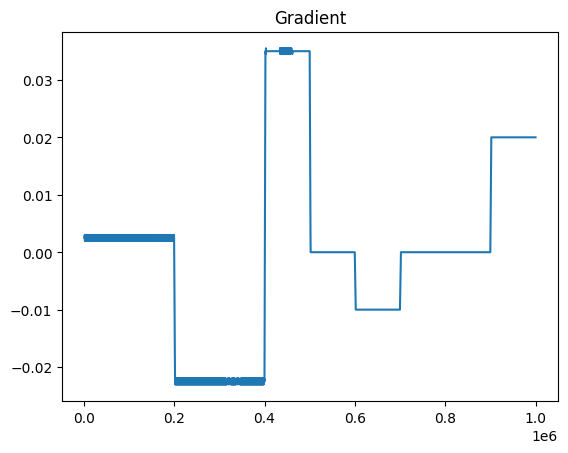

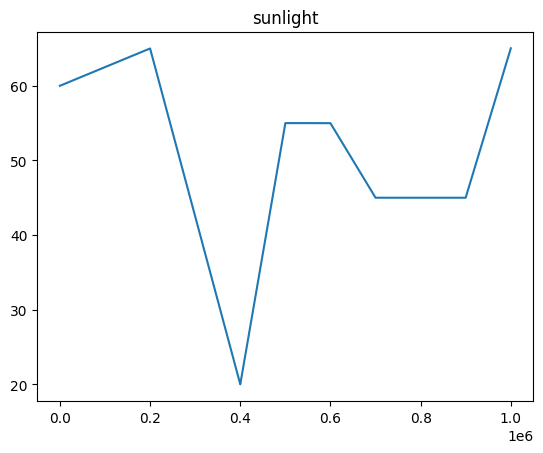

In [182]:
sunlight = obs['sunlightIndex']

gradient = sunlight.shift(-1) - sunlight
plt.figure()
plt.title("Gradient")
plt.plot(obs['timestamp'], gradient.rolling(20).mean())


plt.figure()
plt.title("sunlight")
plt.plot(obs['timestamp'], sunlight)
 

md

macaron ADF p‑value = 0.350
sugar ADF p‑value = 0.546


<Figure size 600x400 with 0 Axes>

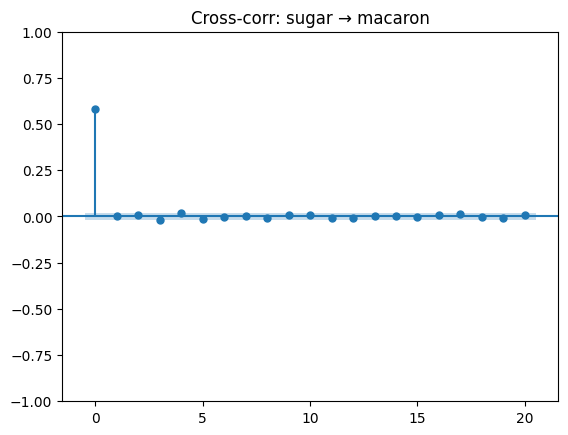

Does sugar → macaron?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.0390 , p=0.0000  , df_denom=9995, df_num=1
ssr based chi2 test:   chi2=24.0462 , p=0.0000  , df=1
likelihood ratio test: chi2=24.0174 , p=0.0000  , df=1
parameter F test:         F=24.0390 , p=0.0000  , df_denom=9995, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.0626 , p=0.0000  , df_denom=9992, df_num=2
ssr based chi2 test:   chi2=24.1372 , p=0.0000  , df=2
likelihood ratio test: chi2=24.1081 , p=0.0000  , df=2
parameter F test:         F=12.0626 , p=0.0000  , df_denom=9992, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.3326  , p=0.0000  , df_denom=9989, df_num=3
ssr based chi2 test:   chi2=25.0152 , p=0.0000  , df=3
likelihood ratio test: chi2=24.9840 , p=0.0000  , df=3
parameter F test:         F=8.3326  , p=0.0000  , df_denom=9989, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:   

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=2.3587  , p=0.0006  , df_denom=9938, df_num=20
ssr based chi2 test:   chi2=47.3686 , p=0.0005  , df=20
likelihood ratio test: chi2=47.2565 , p=0.0005  , df=20
parameter F test:         F=2.3587  , p=0.0006  , df_denom=9938, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.3291  , p=0.0005  , df_denom=9935, df_num=21
ssr based chi2 test:   chi2=49.1224 , p=0.0005  , df=21
likelihood ratio test: chi2=49.0018 , p=0.0005  , df=21
parameter F test:         F=2.3291  , p=0.0005  , df_denom=9935, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.2719  , p=0.0006  , df_denom=9932, df_num=22
ssr based chi2 test:   chi2=50.2080 , p=0.0005  , df=22
likelihood ratio test: chi2=50.0821 , p=0.0006  , df=22
parameter F test:         F=2.2719  , p=0.0006  , df_denom=9932, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.2661  , p=0.0005  , df_denom=9929, df_num=2

C:\Users\raoj6\AppData\Local\Microsoft\WindowsApps\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.1482  , p=0.3183  , df_denom=9965, df_num=11
ssr based chi2 test:   chi2=12.6598 , p=0.3161  , df=11
likelihood ratio test: chi2=12.6518 , p=0.3167  , df=11
parameter F test:         F=1.1482  , p=0.3183  , df_denom=9965, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.0436  , p=0.4047  , df_denom=9962, df_num=12
ssr based chi2 test:   chi2=12.5552 , p=0.4022  , df=12
likelihood ratio test: chi2=12.5473 , p=0.4028  , df=12
parameter F test:         F=1.0436  , p=0.4047  , df_denom=9962, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=0.9890  , p=0.4590  , df_denom=9959, df_num=13
ssr based chi2 test:   chi2=12.8920 , p=0.4562  , df=13
likelihood ratio test: chi2=12.8837 , p=0.4568  , df=13
parameter F test:         F=0.9890  , p=0.4590  , df_denom=9959, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=0.9627  , p=0.4894  , df_denom=9956, df_num=1

{1: ({'ssr_ftest': (0.7618872959048855, 0.38275951143679177, 9995.0, 1),
   'ssr_chi2test': (0.7621159764339216, 0.3826671434153246, 1),
   'lrtest': (0.7620869310485432, 0.3826762110201717, 1),
   'params_ftest': (0.7618872958949365, 0.3827595114395642, 9995.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8778288660907758, 0.4157164943228977, 9992.0, 2),
   'ssr_chi2test': (1.7565362638729956, 0.41550188336195004, 2),
   'lrtest': (1.7563819646675256, 0.4155339404037651, 2),
   'params_ftest': (0.8778288660902476, 0.4157164943228977, 9992.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.4270482024748903, 0.23273053692357581, 9989.0, 3),
   'ssr_chi2test': (4.284144708761339, 0.23237127008554673, 3),
   'lrtest': (4.2832269089558395, 0.23246026727243693, 3),
   'params_ftest': (1.4270482024727305, 0.23273053692453027, 9989.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [183]:
from statsmodels.tsa.stattools import adfuller

for name, series in [('macaron', md['mid_price']),
                     ('sugar',    obs['sugarPrice'])]:
    stat, p, *_ = adfuller(series.dropna())
    print(f"{name} ADF p‑value = {p:.3f}")

macaron_ret = md['mid_price'].diff().dropna()
sugar_ret   = obs['sugarPrice'].diff().dropna()
from statsmodels.graphics.tsaplots import plot_ccf
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plot_ccf(sugar_ret, macaron_ret, lags=20)
plt.title("Cross‑corr: sugar → macaron")
plt.show()

from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd

# build a 2‑column DataFrame of both differenced series
df = pd.concat([macaron_ret, sugar_ret], axis=1).dropna()
df.columns = ['macaron', 'sugar']

# test maxlag=5 (you can adjust)
print("Does sugar → macaron?")
grangercausalitytests(df[['macaron','sugar']], maxlag=25, verbose=True)

print("\nDoes macaron → sugar?")
grangercausalitytests(df[['sugar','macaron']], maxlag=25, verbose=True)



All these 0.00 mean that we have strong evidence that past sugar prices help predict macarons.

In [184]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 1. Compute returns
mac_ret = np.log(md['mid_price']).diff().shift(-1)
sug_ret = np.log(obs['sugarPrice']).diff()

# 2. Put them together
df = pd.DataFrame({
    'mac_ret': mac_ret,
    'sugar':   sug_ret
}).dropna()

# 3. Add rolling stats
df['sugar_ma7']    = df['sugar'].rolling(7).mean()
df['sugar_vol30']  = df['sugar'].rolling(30).std()

# 4. Add sugar lags 1…10
for lag in range(1, 11):
    df[f'sugar_lag{lag}'] = df['sugar'].shift(lag)

# 5. Drop any NaNs created by rolling/lagging
df.dropna(inplace=True)

# 6. Split features vs target
feature_cols = [c for c in df.columns if c != 'mac_ret']
X = df[feature_cols]
y = df['mac_ret']

# 7. Time‑based train/test split
split = int(len(df)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 8. Fit & evaluate a Ridge baseline
model = Ridge(alpha=0.01)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, pred))
print("R²: ", r2_score(y_test, pred))

# 9. (Optional) tune α with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(Ridge(), {'alpha':[0.01,0.1,1,10]}, cv=tscv,
                    scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best α:", grid.best_params_['alpha'])


MSE: 1.4122841098694495e-05
R²:  -0.0008757568842368002
Best α: 0.1
